# **Título del trabajo:** FitBite: Aplicación móvil para la recomendación de comidas saludables con funcionalidad de clasificación de imágenes

**3era versión del código para Clasificación de Imágenes: Frutas y Verduras*

**Curso:** Taller de Construcción de Software Móvil  
**Docente:** Petrlik Azabache, Ivan Carlo  
**Proyecto:** FitBite  
**Grupo:** 1  
**Integrantes:**
- Abanto Salas, Flavia Francesca (19200064)
- Domínguez Matos, Juan Martín (19200275)
- Palacios Barrutia, Jeanpiere Julian (19200274)

**Consideraciones**

- El conjunto de imágenes fue cargado a Google Drive. Para poder usar el dataset es necesario activar la conexión con Google Drive y colocar la ruta del dataset.
- Para el entorno de ejecución Python 3, se recomienda usar un acelerador de hardware GPU. Esto se debe a su velocidad de procesamiento para varias imágenes de nuestro dataset.

**Diferencias con la versión anterior (2da versión)**

- Se consideraron otras frutas y verduras a incluir en el dataset. Esto se justifica en un Reporte del Ministerio de Desarrollo Agrario y Riego (MIDAGRI) del año 2022, donde se señalan las frutas y verduras de mayor producción en el Perú: [Situación actual de las frutas y verduras en el Perú](https://repositorio.midagri.gob.pe/bitstream/20.500.13036/1227/1/Situaci%c3%b3n%20actual%20de%20frutas%20y%20verduras%20en%20el%20Per%c3%ba.pdf).

**Conexión a archivos de Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importar librerías necesarias

Las librerías a importar son para el manejo y procesamiento de imágenes (ML). Asimismo, se importan librerías para generar gráficos y obtener métricas del modelo.

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

## 2. Definir las rutas de las carpetas de imágenes de entrenamiento, validación y prueba

Se ingresa la ruta donde se encuentra el dataset de frutas y verduras para nuestro modelo de clasificación de imágenes.

In [4]:
dataset_dir = "./drive/MyDrive/frutas_verduras_31"

Se definen cuáles son las rutas donde se encuentran las carpetas de entrenamiento (*train*), prueba (*test*) y validación (*validation*).

In [5]:
train_dir = './drive/MyDrive/frutas_verduras_31/train'
test_dir = './drive/MyDrive/frutas_verduras_31/test'
validation_dir = './drive/MyDrive/frutas_verduras_31/validation'

## 3. Definir los hiperparámetros del modelo

Estos son establecidos antes del entrenamiento de nuestro modelo de clasificación de imágenes.

In [13]:
batch_size = 32
epochs = 20
img_height = 224
img_width = 224
num_classes = 31

## 4. Preprocesar y conocer número de imágenes de las carpetas de entrenamiento, validación y prueba

Para todos los casos, se muestra el número de imágenes a usar para el entrenamiento, prueba y validación. Además, se muestra el número de clases que corresponde a las imágenes encontradas en las rutas de las carpetas de entrenamiento, prueba y validación.

### **Preprocesar las imágenes del conjunto de entrenamiento**

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 6045 images belonging to 31 classes.


### **Preprocesar las imágenes del conjunto de prueba**

In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 775 images belonging to 31 classes.


### **Preprocesar las imágenes del conjunto de validación**

In [9]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 775 images belonging to 31 classes.


## 5. Conocer las clases de imágenes del conjunto de datos

Se crea una función para visualizar la primera imagen de cada clase del dataset. Para ello, se crea un canvas, el cual permitirá generar una imagen de cada una de las clases del dataset. Además, en al función se especifica el nombre de la clase de una imagen, la cual aparecerá en la parte superior de dicha imagen.

In [10]:
from PIL import Image, ImageDraw, ImageFont
import os

def visualize_first_images(data_dir, rows, cols, target_size):
    classes = sorted(os.listdir(data_dir))
    images = []
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        img_names = os.listdir(class_dir)
        img_path = os.path.join(class_dir, img_names[0])
        img = Image.open(img_path)
        img = img.resize(target_size)  # Redimensionar la imagen al tamaño deseado
        images.append(img)
    width, height = target_size
    # Crear lienzo (canvas) para todas las imágenes
    canvas = Image.new('RGB', (cols*(width+30), rows*(height+20)+30),(255, 255, 255))
    # Pegar imágenes en el lienzo y agregar texto
    draw = ImageDraw.Draw(canvas)
    for i, (img, cls) in enumerate(zip(images, classes)):
        row = i // cols
        col = i % cols
        canvas.paste(img, (col*width+col*25, row*(height+20)+20))
        draw.text((col*width+col*25, row*(height+20)), cls.encode('utf-8'), fill=(0,0,0))
    canvas.show()

Para visualizar la primera imagen de las clases, ingresamos la ruta del conjunto de entrenamiento (pudo haber sido del conjunto de validación o prueba, la finalidad es mostrar 1 imagen sobre cada clase). Además, se especifica el número de filas y columnas para desplegar las imágenes de las clases del dataset.

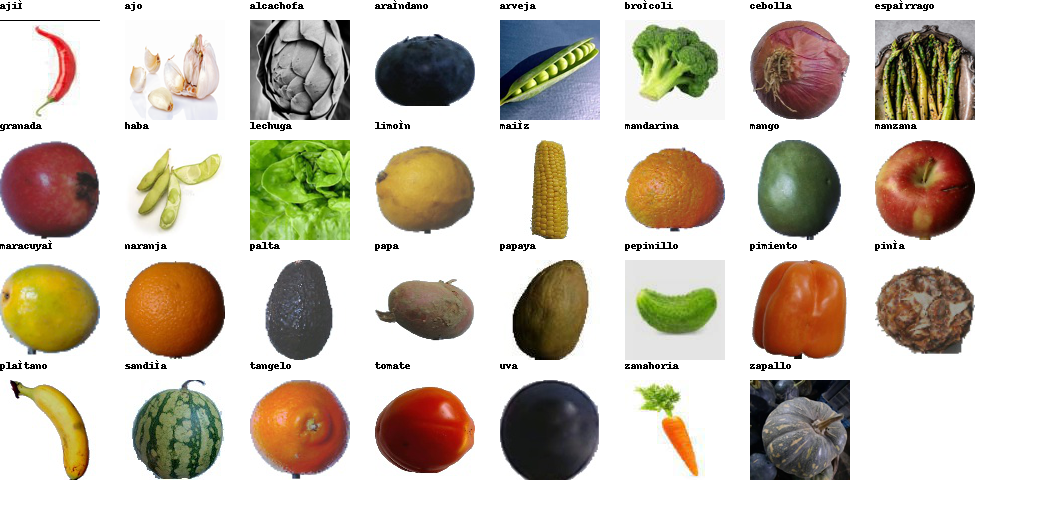

In [11]:
visualize_first_images(train_dir, 4, 8, (100, 100))

## 6. Definir el modelo

### **Crear el modelo**

Se crea un modelo Sequential, por lo que se podrá construir redes neuronales añadiendo capas al modelo.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(31, activation='softmax')
])

### **Compilar el modelo**

Para compilar el modelo es necesario ingresar el algoritmo de optimización para ajustar los pesos del modelo. También, la función de pérdida para evaluar el rendimiento del modelo. Finalmente, se ingresa la métrica *accuracy* para evaluar el rendimiento del modelo durante el entrenamiento y la validación.

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 7. Entrenar el modelo

Se entrena el modelo en la variable *history*. Para esto, se usarán 20 épocas.

In [16]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/20
189/189 [==============================] - 2322s 12s/step - loss: 1.3738 - accuracy: 0.6164 - val_loss: 0.6581 - val_accuracy: 0.7819
Epoch 2/20
189/189 [==============================] - 35s 184ms/step - loss: 0.3612 - accuracy: 0.8875 - val_loss: 0.5451 - val_accuracy: 0.8297
Epoch 3/20
189/189 [==============================] - 32s 167ms/step - loss: 0.1802 - accuracy: 0.9411 - val_loss: 0.4766 - val_accuracy: 0.8568
Epoch 4/20
189/189 [==============================] - 33s 177ms/step - loss: 0.1150 - accuracy: 0.9629 - val_loss: 0.7246 - val_accuracy: 0.8052
Epoch 5/20
189/189 [==============================] - 31s 166ms/step - loss: 0.0774 - accuracy: 0.9754 - val_loss: 0.6951 - val_accuracy: 0.8452
Epoch 6/20
189/189 [==============================] - 31s 163ms/step - loss: 0.0496 - accuracy: 0.9861 - val_loss: 0.7656 - val_accuracy: 0.8168
Epoch 7/20
189/189 [==============================] - 32s 167ms/step - loss: 0.0475 - accuracy: 0.9861 - val_loss: 0.9778 - val_ac

## 8. Obtener la matriz de confusión

###**Listar los nombres de las clases de las imágenes del dataset**

In [17]:
class_dict = test_generator.class_indices
classes = list(class_dict.keys())
classes.sort()

### **Generar la matriz de confusión**

In [18]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

25/25 [==============================] - 223s 9s/step


### **Plotear la matriz de confusión normalizada**

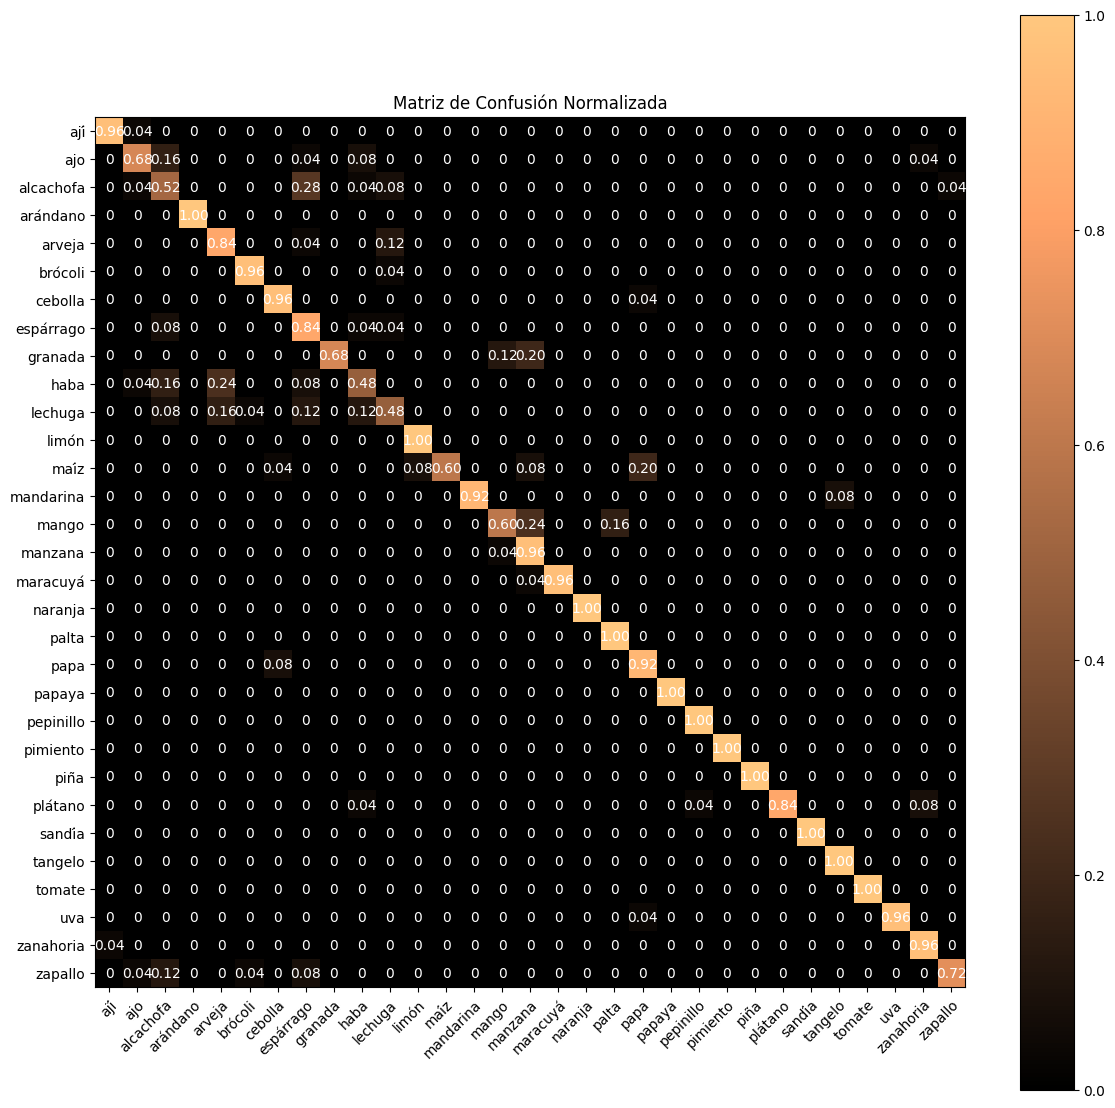

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm, cmap='copper')

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] == 0:
            text = ax.text(j, i, int(cm[i, j]),
                       ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, "{:.2f}".format(cm[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Matriz de Confusión Normalizada")
fig.tight_layout()
plt.colorbar(im)
plt.show()

## 9. Métricas

### **Accuracy**

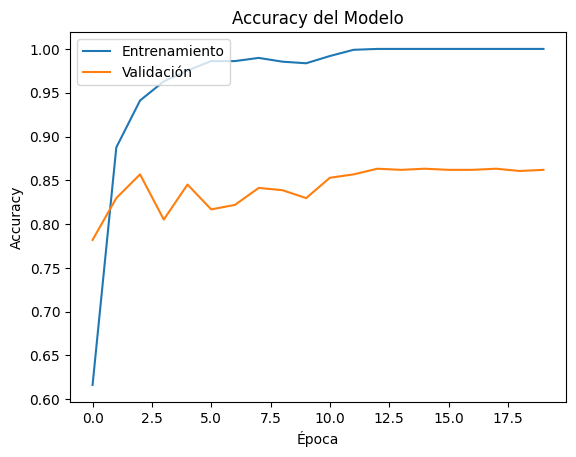

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy del Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [21]:
print("Accuracy entrenamiento: ", history.history['accuracy'])

Accuracy entrenamiento:  [0.6163771748542786, 0.887510359287262, 0.9411083459854126, 0.9629445672035217, 0.9753515124320984, 0.9861041903495789, 0.9861041903495789, 0.9897435903549194, 0.9854425191879272, 0.9836228489875793, 0.9918941259384155, 0.9990074634552002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [22]:
print("Accuracy validación: ", history.history['val_accuracy'])

Accuracy validación:  [0.7819355130195618, 0.829677402973175, 0.8567742109298706, 0.8051612973213196, 0.8451613187789917, 0.8167741894721985, 0.8219354748725891, 0.841290295124054, 0.8387096524238586, 0.829677402973175, 0.8529032468795776, 0.8567742109298706, 0.8632258176803589, 0.8619354963302612, 0.8632258176803589, 0.8619354963302612, 0.8619354963302612, 0.8632258176803589, 0.8606451749801636, 0.8619354963302612]


### **Accuracy Score**

In [23]:
from sklearn.metrics import accuracy_score
accuracyScore = accuracy_score(test_generator.classes, y_pred)
print("Accuracy score: ", accuracyScore)

Accuracy score:  0.8658064516129033


### **Precision Score**

In [24]:
from sklearn.metrics import precision_score
precisionScore = precision_score(test_generator.classes, y_pred, average="macro")
print("Precision score: ", precisionScore)

Precision score:  0.8781218416982168


### **Reporte de Clasificación: Accuracy, Precision, Recall, F1-Score**

In [25]:
from sklearn.metrics import classification_report
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        ají       0.96      0.96      0.96        25
         ajo       0.81      0.68      0.74        25
   alcachofa       0.46      0.52      0.49        25
   arándano       1.00      1.00      1.00        25
      arveja       0.68      0.84      0.75        25
    brócoli       0.92      0.96      0.94        25
     cebolla       0.89      0.96      0.92        25
  espárrago       0.57      0.84      0.68        25
     granada       1.00      0.68      0.81        25
        haba       0.60      0.48      0.53        25
     lechuga       0.63      0.48      0.55        25
      limón       0.93      1.00      0.96        25
       maíz       1.00      0.60      0.75        25
   mandarina       1.00      0.92      0.96        25
       mango       0.79      0.60      0.68        25
     manzana       0.63      0.96      0.76        25
   maracuyá       1.00      0.96      0.98        25
     naranja       1.00    

## 10. Generar del modelo .tflite

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("mml_clasificador_fitbite.tflite", "wb").write(tflite_model)

44696016